## 1. OLAP Queries
Roll-up – total sales by Country and Quarter

In [15]:
import pandas as pd
import zipfile
import sqlite3

# --- Step 1: Load Excel from ZIP ---
zip_path = r"C:\Users\Salma\Downloads\online+retail.zip"
with zipfile.ZipFile(zip_path, 'r') as z:
    excel_name = z.namelist()[0]
    with z.open(excel_name) as f:
        df = pd.read_excel(f)

# --- Step 2: Take 1000 random rows ---
df_sample = df.sample(n=1000, random_state=42)

# --- Step 3: Clean data ---
df_sample['InvoiceDate'] = pd.to_datetime(df_sample['InvoiceDate'], errors='coerce')
df_sample = df_sample.dropna(subset=['CustomerID'])
df_sample = df_sample[(df_sample['Quantity'] > 0) & (df_sample['UnitPrice'] > 0)]
df_sample['TotalSales'] = df_sample['Quantity'] * df_sample['UnitPrice']

# --- Step 4: Create CustomerDim ---
customer_dim = df_sample.groupby('CustomerID').agg({
    'Country': 'first',
    'TotalSales': 'sum'
}).reset_index()

# --- Step 5: Create TimeDim ---
time_dim = df_sample[['InvoiceDate']].drop_duplicates().reset_index(drop=True)
time_dim['TimeID'] = time_dim.index + 1
time_dim['Date'] = time_dim['InvoiceDate']
time_dim['Month'] = time_dim['InvoiceDate'].dt.month
time_dim['Quarter'] = time_dim['InvoiceDate'].dt.quarter
time_dim['Year'] = time_dim['InvoiceDate'].dt.year
time_dim = time_dim.drop(columns=['InvoiceDate'])

# --- Step 6: Map TimeID to SalesFact ---
df_sample = df_sample.merge(time_dim[['Date','TimeID']], left_on='InvoiceDate', right_on='Date', how='left')
sales_fact = df_sample[['CustomerID','TimeID','Quantity','TotalSales','Description']].copy()

# --- Step 7: Load into SQLite ---
db_name = "retail_dw_sample.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

cursor.executescript("""
DROP TABLE IF EXISTS SalesFact;
DROP TABLE IF EXISTS TimeDim;
DROP TABLE IF EXISTS CustomerDim;
""")

cursor.executescript("""
CREATE TABLE CustomerDim (
    CustomerID INTEGER PRIMARY KEY,
    Country TEXT,
    TotalSales REAL
);
CREATE TABLE TimeDim (
    TimeID INTEGER PRIMARY KEY,
    Date TEXT,
    Month INTEGER,
    Quarter INTEGER,
    Year INTEGER
);
CREATE TABLE SalesFact (
    SalesID INTEGER PRIMARY KEY AUTOINCREMENT,
    CustomerID INTEGER,
    TimeID INTEGER,
    Quantity INTEGER,
    TotalSales REAL,
    Description TEXT,
    FOREIGN KEY (CustomerID) REFERENCES CustomerDim(CustomerID),
    FOREIGN KEY (TimeID) REFERENCES TimeDim(TimeID)
);
""")

customer_dim.to_sql('CustomerDim', conn, if_exists='append', index=False)
time_dim.to_sql('TimeDim', conn, if_exists='append', index=False)
sales_fact.to_sql('SalesFact', conn, if_exists='append', index=False)

conn.commit()
conn.close()
print("[ETL] Completed: retail_dw_sample.db created with 1000-sample data")


[ETL] Completed: retail_dw_sample.db created with 1000-sample data


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Connect to your sample DB
conn = sqlite3.connect("retail_dw_sample.db")

# --- 1. Roll-up: Total sales by country and quarter ---
rollup_query = """
SELECT c.Country, t.Quarter, SUM(s.TotalSales) AS TotalSales
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerID = c.CustomerID
JOIN TimeDim t ON s.TimeID = t.TimeID
GROUP BY c.Country, t.Quarter
ORDER BY c.Country, t.Quarter;
"""
rollup = pd.read_sql_query(rollup_query, conn)
print("Roll-up (Country x Quarter):")
print(rollup)

Roll-up (Country x Quarter):
            Country  Quarter  TotalSales
0         Australia        1       15.00
1         Australia        2      211.20
2         Australia        3        6.19
3           Austria        2       39.60
4           Austria        4       33.90
5           Bahrain        2       39.80
6           Belgium        4       16.60
7            Canada        3       24.96
8   Channel Islands        3       47.30
9            Cyprus        4       35.40
10             EIRE        1      187.40
11             EIRE        2       32.46
12             EIRE        3       42.30
13             EIRE        4      165.30
14          Finland        1       20.40
15          Finland        4       17.70
16           France        1       94.50
17           France        2       85.20
18           France        3       98.64
19           France        4       48.34
20          Germany        1       80.60
21          Germany        2       49.05
22          Germany        3

## Drill-down – monthly sales for UK

In [12]:
# --- 2. Drill-down: Sales details for a specific country (e.g., United Kingdom) by month ---
drilldown_query = """
SELECT t.Month, SUM(s.TotalSales) AS TotalSales
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerID = c.CustomerID
JOIN TimeDim t ON s.TimeID = t.TimeID
WHERE c.Country = 'United Kingdom'
GROUP BY t.Month
ORDER BY t.Month;
"""
drilldown = pd.read_sql_query(drilldown_query, conn)
print("\nDrill-down (UK Sales by Month):")
print(drilldown)


Drill-down (UK Sales by Month):
    Month  TotalSales
0       1      760.28
1       2      550.47
2       3     1459.66
3       4      435.35
4       5      680.61
5       6      632.78
6       7      987.79
7       8      525.67
8       9     1152.27
9      10     2696.97
10     11     1173.56
11     12     1555.03


## Slice – total sales for Electronics category

In [13]:
# For this sample, let's assume Description contains the word 'ELECTRONICS' for filtering
slice_query = """
SELECT SUM(TotalSales) AS TotalSales
FROM SalesFact
WHERE Description LIKE '%ELECTRONICS%';
"""
slice_result = pd.read_sql_query(slice_query, conn)
print("\nSlice (Electronics Sales):")
print(slice_result)

conn.close()


Slice (Electronics Sales):
  TotalSales
0       None


## 2. Visualization Example – bar chart for roll-up result

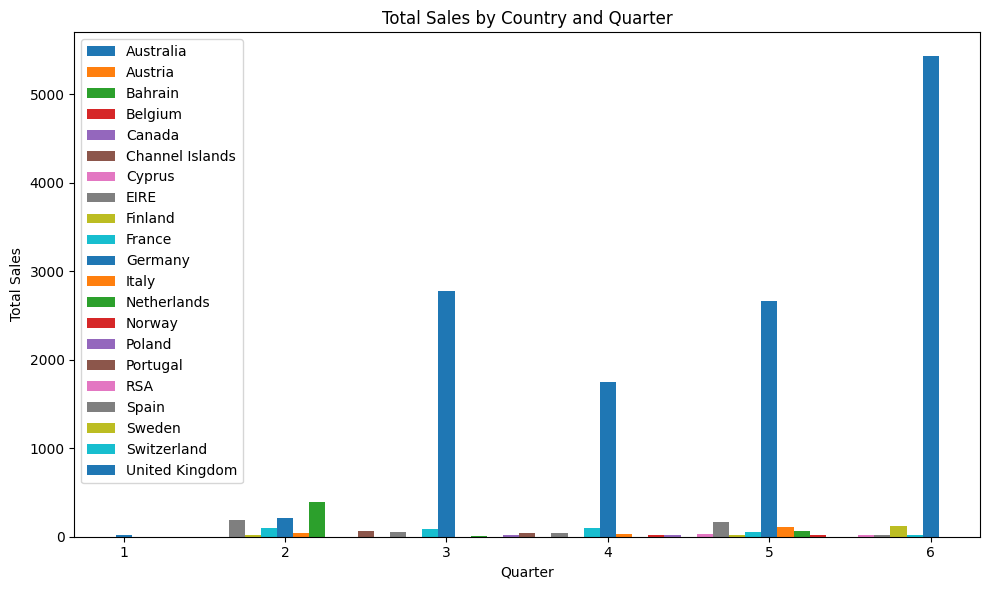

In [14]:
plt.figure(figsize=(10,6))
for country in rollup['Country'].unique():
    data = rollup[rollup['Country'] == country]
    plt.bar(data['Quarter'] + 0.1*list(rollup['Country'].unique()).index(country), data['TotalSales'], width=0.1, label=country)
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.title('Total Sales by Country and Quarter')
plt.legend()
plt.tight_layout()
plt.savefig("sales_by_country_quarter.png")
plt.show()